In [1]:
#import important libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.cluster import SpectralClustering
from numpy import genfromtxt
import numpy as np
from scipy.linalg import null_space
from sklearn.cluster import KMeans
import knn as myKNN
import networkx as nx
from sklearn.covariance import graphical_lasso

In [2]:
bank = pd.read_csv("bank-full.csv", sep=',')
#df is the attributes of people with index as their ids
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
fair_column = 'marital'
fair_values = ['single','married','divorced']
bank = bank[bank[fair_column].isin(fair_values)]

In [4]:
fair_counts = sorted(dict(zip(bank[fair_column].value_counts().index, bank[fair_column].value_counts().values)).items(), key=lambda x:x[1], reverse=True)
assert len(fair_counts) == 3, "Fair counts should equal two."
print("\nDistribution of '%s' column - "%(fair_column), fair_counts)


Distribution of 'marital' column -  [('married', 27214), ('single', 12790), ('divorced', 5207)]


In [5]:
outcome = list[bank['y']]
bank = bank.drop(['contact','poutcome','y'], axis=1)

In [6]:
bank['job'] = bank['job'].map(dict(zip(bank.job.unique(),range(1,len(bank.job.unique())+1))))
bank['marital'] = bank['marital'].map(dict(zip(bank.marital.unique(),range(0,len(bank.marital.unique())+1))))
bank['education'] = bank['education'].map(dict(zip(bank.education.unique(),range(1,len(bank.education.unique())+1))))
bank['default'] = bank['default'].map(dict(zip(bank.default.unique(),range(0,len(bank.default.unique())+1))))
bank['housing'] = bank['housing'].map(dict(zip(bank.housing.unique(),range(0,len(bank.housing.unique())+1))))
bank['loan'] = bank['loan'].map(dict(zip(bank.loan.unique(),range(1,len(bank.loan.unique())+1))))
bank['month'] = bank['month'].map(dict(zip(bank.month.unique(),range(1,len(bank.month.unique())+1))))

In [7]:
random_state = 21
split_size = [300,300,300]
bank = bank[bank[fair_column]==2].sample(max(split_size),random_state=random_state).append(bank[bank[fair_column]==1].sample(min(split_size), random_state=random_state), ignore_index=True).append(bank[bank[fair_column]==0].sample(min(split_size), random_state=random_state), ignore_index=True)
fair_values = list(bank['marital'])
bank = bank.drop(['marital'], axis=1)
bank.shape

(900, 13)

In [8]:
bank_list = bank.to_numpy()
len(bank_list)

900

In [9]:
len(fair_values)

900

In [10]:
W_knn = myKNN.get_knn(bank_list, k = 10)

In [11]:
W_knn.shape

(900, 900)

In [12]:
color_map = []
for val in fair_values:
    if(val == 0):
        color_map.append("red")
    elif(val == 1):
        color_map.append("blue")
    elif(val == 2):
        color_map.append("green")

In [13]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=100, node_color = color_map, with_labels=False)
    plt.show()

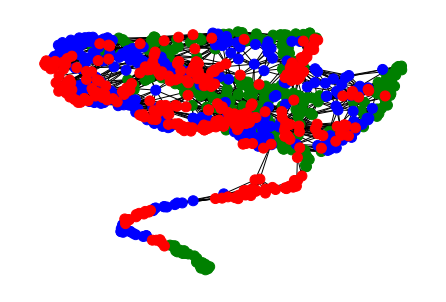

In [14]:
show_graph_with_labels(W_knn)

In [16]:
W_knn.shape

(900, 900)

In [17]:
# degree matrix
D = np.diag(np.sum(W_knn, axis=1))
D.shape

(900, 900)

In [18]:
# laplacian matrix
L = D - W_knn
print('laplacian matrix:')
print(L)

laplacian matrix:
[[ 7.9954296   0.          0.         ...  0.          0.
   0.        ]
 [ 0.          8.43203169  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         11.49897819 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  9.97645988  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         12.49652058
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   9.48471096]]


In [31]:
e, v = np.linalg.eig(L)
e = e.real
v = v.real
res = dict(zip(e, v))
eig = dict(sorted(res.items()))
del eig[list(eig.keys())[0]]

In [32]:
Y=[]
clusters=4
for i in range(clusters):
    Y.append(eig[list(eig.keys())[i]])
Y=np.array(Y)
Y.shape

(4, 900)

In [33]:
Y=Y.T
Y.shape

(900, 4)

In [34]:
k_Means_Obj=KMeans(n_clusters=4)
k_Means_Obj.fit(Y)

KMeans(n_clusters=4)

In [35]:
clusters_cen=k_Means_Obj.cluster_centers_
clusters_cen

array([[ 4.31912235e-03,  2.34685462e-03,  7.44256456e-04,
        -4.61447341e-03],
       [-8.69463295e-02,  6.36728799e-04, -2.93212440e-03,
        -1.61806249e-03],
       [ 5.90357523e-03,  1.08224373e-04,  8.69044523e-04,
         8.20530495e-02],
       [ 6.92063130e-04, -9.44441209e-04,  3.62844280e-01,
        -2.48491923e-03]])

In [36]:
final=k_Means_Obj.fit_predict(Y)
final

array([0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 1, 0,
       0, 2, 3, 0, 0, 3, 2, 2, 0, 1, 2, 0, 3, 0, 2, 2, 0, 0, 0, 2, 2, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 2, 0, 3, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
def balance_calc(fair_values,clusters):
    k = len(set(clusters))
    h = len(set(fair_values))
    bal_list = []
    for i in range(k):
        bal_list.append(np.zeros(len(set(fair_values))))
    for index,val in enumerate(clusters):
        bal_list[val][fair_values[index]] += 1
    balance = 0
    for i in range(k):
        temp = []
        for j in range(h):
            for l in range(j+1,h):
                p = bal_list[i][j]
                q = bal_list[i][l]
                if(p == 0 or q == 0):
                    temp.append(0)
                    temp.append(0)
                else:
                    temp.append(p/q)
                    temp.append(q/p)
        balance += min(temp)
    balance /= k
    return balance

In [38]:
print(balance_calc(fair_values,final))

0.5756416392542748
